In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

from IPython.display import display, HTML

/Users/surabhisnath/Nextcloud/Documents/PhD/Code/projects/process_modelling/process_modelling/.env_process_modelling/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}   
    mean_similarities = {}                                                   # find min paiwise text similarity in each cluster
                                                                            # find mean paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        mean_sim = np.mean(sim)
        mean_similarities[cl] = mean_sim
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
        

    # code to get interpretation of each cluster 
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")
    
    print(mean_similarities)
    cluster_sizes = [len(cluster_to_response[key]) for key in cluster_to_response]
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    ax[0].hist(cluster_sizes, color="lightseagreen")
    ax[0].set_xlabel("Cluster Size")
    ax[0].set_ylabel("Frequency")
    ax[1].hist(list(mean_similarities.values()), color="lightseagreen")
    ax[1].set_xlabel("Cluster Mean Pairwise Similarity")
    ax[1].set_ylabel("Frequency")
    plt.show()

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities, mean_similarities

def perform_hierarchicalClustering(embeddings, texts, method, printclusters, ax=None):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        type (tuple): a: distance/maxclust based clustering, b: distance threshold/max number of clusters
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    
    if ax is not None:
        # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
        mean_minsemsim = []
        num_clusters = []
        for cod in np.linspace(1, 8, 30):
            cluster_assignment = fcluster(linked, t=cod, criterion='distance')
            _, _, _, minsims, _ = get_clusters(embeddings, texts, cluster_assignment, False)
            mean_minsemsim.append(np.mean(list(minsims.values())))
            num_clusters.append(len(np.unique(cluster_assignment)))
    
        dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
        ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
        ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
        ax[2].plot(np.linspace(1, 8, 30), num_clusters)
        ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=method[1], criterion=method[0])         # assign clusters
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def permform_KMeans(embeddings, texts, method, printclusters):
    kmeans = KMeans(n_clusters=method[1], random_state=42)
    kmeans.fit(embeddings)
    cluster_assignment = kmeans.labels_
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)       # embeddings are already normalised so no need to divide by norm
    else:
        return 0

def normalize(embedding):
    norm = np.linalg.norm(embedding)
    if norm == 0:
        return embedding  # Return as-is if it's a zero vector
    return embedding / norm

def get_similarity_matrix(embeddings):
    embedding_matrix = np.array(embeddings)
    # Since embeddings are already normalized, the cosine similarity is just the dot product
    similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)
    return similarity_matrix

def plot_heatmap(matrix, texts, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="coolwarm", annot=True)
    plt.title(title)
    plt.show()

def write_category_SS_jump(taskid, model, context, algo, embeddings, response_to_cluster):
    data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
    data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calculate_cosine_similarity(embeddings.get(row['response']), embeddings.get(row['previous_response'])), axis=1)
    
    data[f"jump_cat_{model}_{context}_{algo}"] = (~(data[f"category_{model}_{context}_{algo}"].diff() == 0)).astype(int)
    data[f"jump_SS_{model}_{context}_{algo}"] = (data[f"SS_{model}_{context}_{algo}"] < 0.8).astype(int)
    data.loc[data["task"] == taskid, f'jump_{model}_{context}_{algo}'] = data[f"jump_cat_{model}_{context}_{algo}"] & data[f"jump_SS_{model}_{context}_{algo}"]

def get_cluster_agreement(cluster_assignment1, cluster_assignment2):
    ari = adjusted_rand_score(cluster_assignment1, cluster_assignment2)
    nmi = normalized_mutual_info_score(cluster_assignment1, cluster_assignment2)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(cluster_assignment1, cluster_assignment2)
    return f"{np.round(ari, 1)}, {np.round(nmi, 1)}, {np.round(homogeneity, 1)}, {np.round(completeness, 1)}, {np.round(v_measure, 1)}"

def get_jump_agreement(data, task, jumpcol1, jumpcol2):
    cm = confusion_matrix(data[data["task"] == task][jumpcol1], data[data["task"] == task][jumpcol2])
    print(cm)
    TN, FP, FN, TP = cm.ravel()

    # Calculate TPR, FPR, TNR, FNR
    TPR = TP / (TP + FN)  # Sensitivity, Recall
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)  # Specificity
    FNR = FN / (TP + FN)

    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"True Negative Rate (TNR): {TNR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    print(f"False Negative Rate (FNR): {FNR:.2f}")

In [3]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")
texts_autbrick = data[data["task"] == 2]["response"].unique().tolist()
texts_autpaperclip = data[data["task"] == 3]["response"].unique().tolist()
texts_vf = data[data["task"] == 1]["response"].unique().tolist()
texts = [texts_autbrick, texts_autpaperclip, texts_vf]
tasks = ["autbrick", "autpaperclip", "vf"]
taskid = [2, 3, 1]
task_to_id = {"autbrick": 2, "autpaperclip": 3, "vf": 1}

In [4]:
models = ["qwen", "stella", "gtelarge", "jxm"]
contexts = ["noshortcontext", "nearshortcontext", "farshortcontext"]
algos = ["hier", "kmeans"]

# nocontext - only text embedding
# nearcontext - task keyword (brick/paperclip/animal) + text embedding
# farcontext - different task keyword (animal/brick/paperclip) + text embedding

In [5]:
printclusters = False

autbrick qwen noshortcontext hier
{np.int32(1): np.float32(0.9820047), np.int32(20): np.float32(0.48570815), np.int32(10): np.float32(0.39131787), np.int32(7): np.float32(0.5615333), np.int32(18): np.float32(0.56272465), np.int32(13): np.float32(0.4172495), np.int32(17): np.float32(0.49913028), np.int32(8): np.float32(0.55140805), np.int32(6): np.float32(0.708433), np.int32(19): np.float32(0.7001268), np.int32(4): np.float32(0.57325846), np.int32(16): np.float32(0.5522891), np.int32(5): np.float32(0.51147646), np.int32(14): np.float32(0.4724916), np.int32(12): np.float32(0.649158), np.int32(22): np.float32(0.55710775), np.int32(25): np.float32(0.4330407), np.int32(15): np.float32(0.45624545), np.int32(2): np.float32(0.62773085), np.int32(3): np.float32(0.5163632), np.int32(24): np.float32(0.64198655), np.int32(21): np.float32(0.67733365), np.int32(23): np.float32(0.630068), np.int32(11): np.float32(0.54584223), np.int32(9): np.float32(0.5791915)}


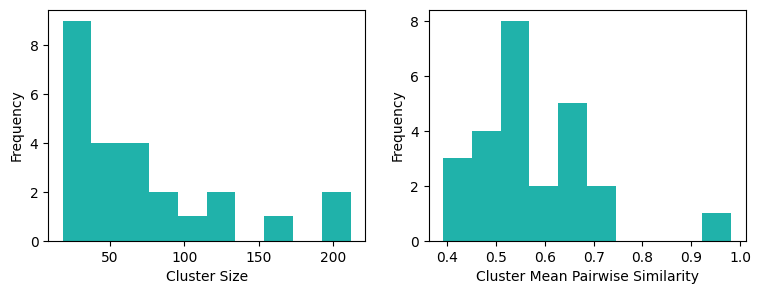

Num clusters = 25
autbrick qwen noshortcontext kmeans
{np.int32(4): np.float32(0.9820047), np.int32(1): np.float32(0.4259162), np.int32(16): np.float32(0.4638801), np.int32(24): np.float32(0.54547346), np.int32(7): np.float32(0.4759299), np.int32(8): np.float32(0.46693754), np.int32(2): np.float32(0.5554615), np.int32(5): np.float32(0.5529694), np.int32(19): np.float32(0.5700985), np.int32(21): np.float32(0.41019157), np.int32(14): np.float32(0.54150987), np.int32(11): np.float32(0.55428255), np.int32(10): np.float32(0.5012093), np.int32(13): np.float32(0.50490546), np.int32(22): np.float32(0.5395123), np.int32(20): np.float32(0.56380624), np.int32(15): np.float32(0.5957743), np.int32(12): np.float32(0.45577407), np.int32(9): np.float32(0.6164025), np.int32(23): np.float32(0.57854265), np.int32(17): np.float32(0.54630774), np.int32(6): np.float32(0.52967596), np.int32(3): np.float32(0.48997706), np.int32(0): np.float32(0.6070282), np.int32(18): np.float32(0.60369045)}


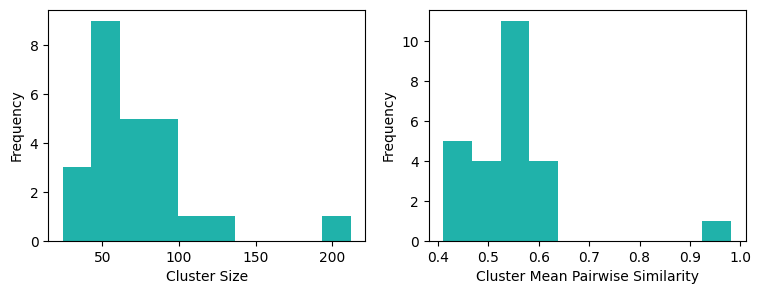

Num clusters = 25
autbrick qwen nearshortcontext hier
{np.int32(18): np.float32(0.97934353), np.int32(6): np.float32(0.99020016), np.int32(17): np.float32(0.9792095), np.int32(19): np.float32(0.98599607), np.int32(11): np.float32(0.98320454), np.int32(1): np.float32(0.9812571), np.int32(4): np.float32(0.98912513), np.int32(16): np.float32(0.98594946), np.int32(21): np.float32(0.9826543), np.int32(10): np.float32(0.9844044), np.int32(9): np.float32(0.98965895), np.int32(8): np.float32(0.99119776), np.int32(22): np.float32(0.9938886), np.int32(5): np.float32(0.9869044), np.int32(23): np.float32(0.9835625), np.int32(7): np.float32(0.9885249), np.int32(3): np.float32(0.9836442), np.int32(20): np.float32(0.98264295), np.int32(25): np.float32(0.9808595), np.int32(13): np.float32(0.98113143), np.int32(2): np.float32(0.98201185), np.int32(14): np.float32(0.992727), np.int32(12): np.float32(0.98463917), np.int32(15): np.float32(0.98662484), np.int32(24): np.float32(0.99342465)}


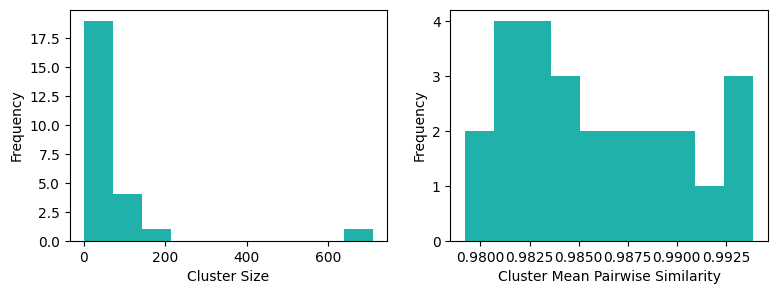

Num clusters = 25
autbrick qwen nearshortcontext kmeans
{np.int32(3): np.float32(0.98310816), np.int32(11): np.float32(0.9927641), np.int32(9): np.float32(0.9896276), np.int32(16): np.float32(0.97929245), np.int32(7): np.float32(0.98168755), np.int32(5): np.float32(0.9880092), np.int32(6): np.float32(0.9737927), np.int32(15): np.float32(0.9805065), np.int32(4): np.float32(0.9850916), np.int32(2): np.float32(0.9818714), np.int32(21): np.float32(0.9812846), np.int32(1): np.float32(0.9834755), np.int32(22): np.float32(0.990068), np.int32(8): np.float32(0.98502773), np.int32(14): np.float32(0.99006116), np.int32(12): np.float32(0.9835476), np.int32(13): np.float32(0.9859008), np.int32(17): np.float32(0.9855059), np.int32(24): np.float32(0.98247963), np.int32(20): np.float32(0.98363054), np.int32(18): np.float32(0.98463917), np.int32(19): np.float32(0.99145365), np.int32(0): np.float32(0.99398386), np.int32(10): np.float32(0.9906613), np.int32(23): np.float32(0.9951454)}


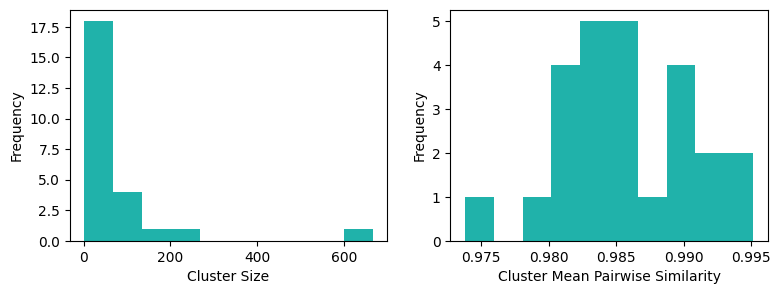

Num clusters = 25
autbrick qwen farshortcontext hier
{np.int32(22): np.float32(0.99388486), np.int32(10): np.float32(0.98967713), np.int32(2): np.float32(0.99635047), np.int32(5): np.float32(0.99422115), np.int32(16): np.float32(0.99234015), np.int32(25): np.float32(0.9901141), np.int32(23): np.float32(0.9912332), np.int32(9): np.float32(0.9911706), np.int32(3): np.float32(0.9946911), np.int32(18): np.float32(0.9935723), np.int32(21): np.float32(0.9960078), np.int32(20): np.float32(0.99406576), np.int32(1): np.float32(0.99353707), np.int32(7): np.float32(0.9911813), np.int32(17): np.float32(0.9951844), np.int32(19): np.float32(0.99493456), np.int32(6): np.float32(0.99507004), np.int32(15): np.float32(0.9919518), np.int32(12): np.float32(0.989357), np.int32(13): np.float32(0.9970841), np.int32(11): np.float32(0.9884443), np.int32(4): np.float32(0.97708684), np.int32(14): np.float32(0.99158984), np.int32(24): np.float32(0.99518067), np.int32(8): np.float32(0.9894183)}


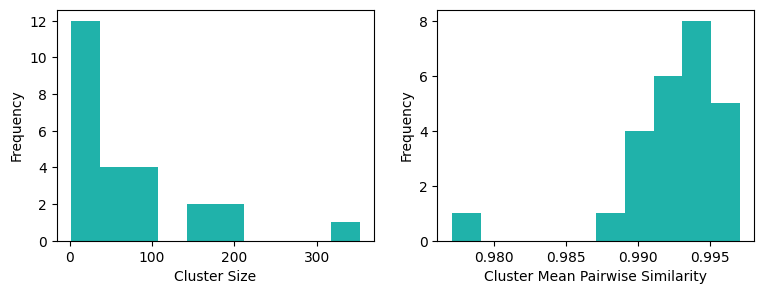

Num clusters = 25
autbrick qwen farshortcontext kmeans
{np.int32(1): np.float32(0.99587286), np.int32(16): np.float32(0.9924584), np.int32(10): np.float32(0.99308795), np.int32(6): np.float32(0.98982114), np.int32(13): np.float32(0.98981154), np.int32(5): np.float32(0.9943654), np.int32(11): np.float32(0.98890215), np.int32(21): np.float32(0.99364555), np.int32(8): np.float32(0.99390703), np.int32(24): np.float32(0.99393547), np.int32(17): np.float32(0.99112165), np.int32(3): np.float32(0.99313164), np.int32(20): np.float32(0.99326867), np.int32(0): np.float32(0.9921664), np.int32(2): np.float32(0.9950369), np.int32(12): np.float32(0.9912634), np.int32(4): np.float32(0.99158686), np.int32(9): np.float32(0.9876271), np.int32(23): np.float32(0.9970841), np.int32(18): np.float32(1.0000002), np.int32(14): np.float32(0.98996085), np.int32(22): np.float32(0.9953439), np.int32(7): np.float32(0.99332863), np.int32(19): np.float32(1.0), np.int32(15): np.float32(1.0000001)}


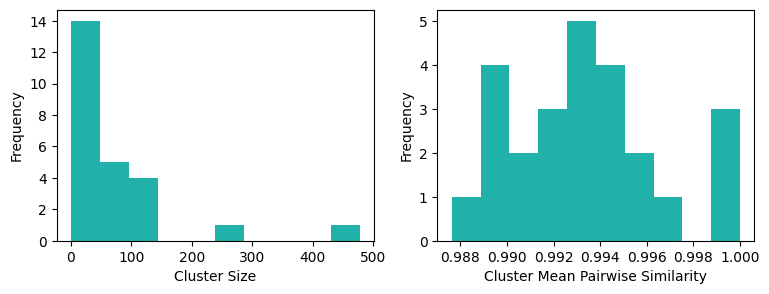

Num clusters = 25
autbrick stella noshortcontext hier
{np.int32(24): np.float32(0.7035292), np.int32(21): np.float32(0.5830471), np.int32(13): np.float32(0.60738593), np.int32(20): np.float32(0.67152506), np.int32(23): np.float32(0.5995489), np.int32(11): np.float32(0.66866416), np.int32(17): np.float32(0.5651899), np.int32(9): np.float32(0.66424567), np.int32(10): np.float32(0.7366883), np.int32(19): np.float32(0.63479346), np.int32(22): np.float32(0.580612), np.int32(15): np.float32(0.60780954), np.int32(14): np.float32(0.75377506), np.int32(12): np.float32(0.6668602), np.int32(5): np.float32(0.6635407), np.int32(4): np.float32(0.620629), np.int32(2): np.float32(0.64558196), np.int32(6): np.float32(0.69365346), np.int32(16): np.float32(0.6418217), np.int32(1): np.float32(0.8195592), np.int32(7): np.float32(0.6246537), np.int32(18): np.float32(0.7587638), np.int32(3): np.float32(0.77696), np.int32(25): np.float32(0.71553457), np.int32(8): np.float32(0.7672537)}


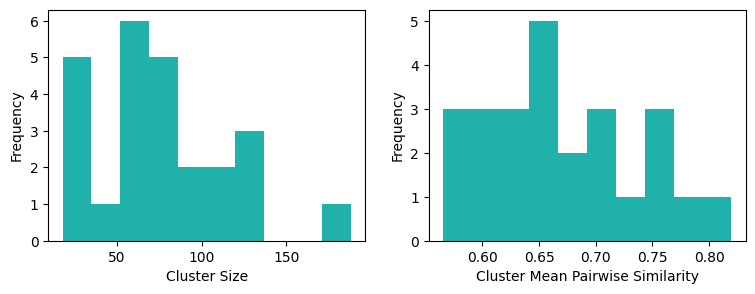

Num clusters = 25
autbrick stella noshortcontext kmeans
{np.int32(14): np.float32(0.60148335), np.int32(23): np.float32(0.6388065), np.int32(22): np.float32(0.6743201), np.int32(7): np.float32(0.627537), np.int32(15): np.float32(0.73236877), np.int32(16): np.float32(0.67012227), np.int32(9): np.float32(0.6990286), np.int32(18): np.float32(0.7038531), np.int32(12): np.float32(0.70452124), np.int32(1): np.float32(0.64991957), np.int32(2): np.float32(0.60094684), np.int32(6): np.float32(0.76048046), np.int32(10): np.float32(0.66711384), np.int32(3): np.float32(0.57132757), np.int32(19): np.float32(0.6413219), np.int32(17): np.float32(0.79467213), np.int32(24): np.float32(0.73301816), np.int32(4): np.float32(0.7058092), np.int32(13): np.float32(0.61391777), np.int32(20): np.float32(0.7862514), np.int32(8): np.float32(0.7183214), np.int32(21): np.float32(0.6667452), np.int32(0): np.float32(0.75168025), np.int32(11): np.float32(0.6977839), np.int32(5): np.float32(0.6691702)}


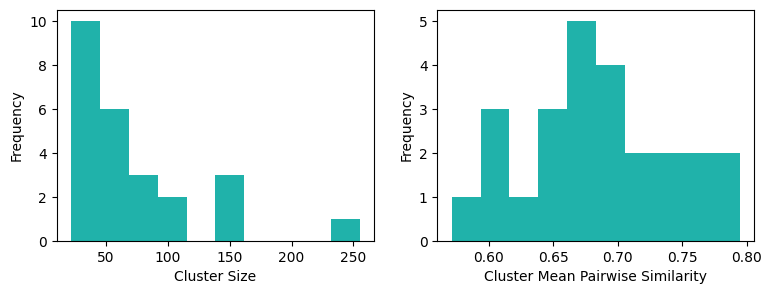

Num clusters = 25
autbrick stella nearshortcontext hier
{np.int32(15): np.float32(0.98067176), np.int32(20): np.float32(0.97177243), np.int32(8): np.float32(0.97804564), np.int32(23): np.float32(0.9824456), np.int32(25): np.float32(0.973237), np.int32(1): np.float32(0.9750585), np.int32(18): np.float32(0.9641384), np.int32(24): np.float32(0.9812693), np.int32(11): np.float32(0.9854166), np.int32(16): np.float32(0.9865066), np.int32(22): np.float32(0.9701501), np.int32(19): np.float32(0.96850693), np.int32(4): np.float32(0.97236735), np.int32(7): np.float32(0.98353755), np.int32(17): np.float32(0.971235), np.int32(6): np.float32(0.9702632), np.int32(21): np.float32(0.97790426), np.int32(5): np.float32(0.9629039), np.int32(14): np.float32(0.9827552), np.int32(12): np.float32(0.96326756), np.int32(3): np.float32(0.97873867), np.int32(13): np.float32(0.97577685), np.int32(2): np.float32(0.97170335), np.int32(10): np.float32(0.96352214), np.int32(9): np.float32(0.9761785)}


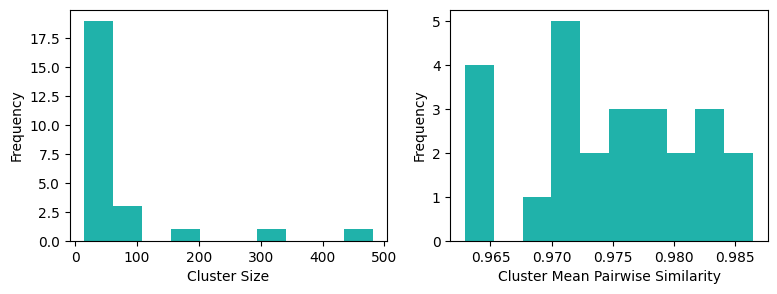

Num clusters = 25
autbrick stella nearshortcontext kmeans
{np.int32(11): np.float32(0.9819533), np.int32(13): np.float32(0.9800836), np.int32(3): np.float32(0.9781216), np.int32(21): np.float32(0.97354096), np.int32(10): np.float32(0.97226965), np.int32(5): np.float32(0.98371905), np.int32(16): np.float32(0.98101187), np.int32(2): np.float32(0.961515), np.int32(8): np.float32(0.96728903), np.int32(22): np.float32(0.97403526), np.int32(12): np.float32(0.98105717), np.int32(24): np.float32(0.9691833), np.int32(1): np.float32(0.9718691), np.int32(4): np.float32(0.97513944), np.int32(19): np.float32(0.9655598), np.int32(6): np.float32(0.98353755), np.int32(20): np.float32(0.9956368), np.int32(0): np.float32(0.98145276), np.int32(14): np.float32(0.9662554), np.int32(7): np.float32(0.97026855), np.int32(9): np.float32(0.97005004), np.int32(17): np.float32(0.9643641), np.int32(23): np.float32(0.9792487), np.int32(15): np.float32(0.9729904), np.int32(18): np.float32(0.9764858)}


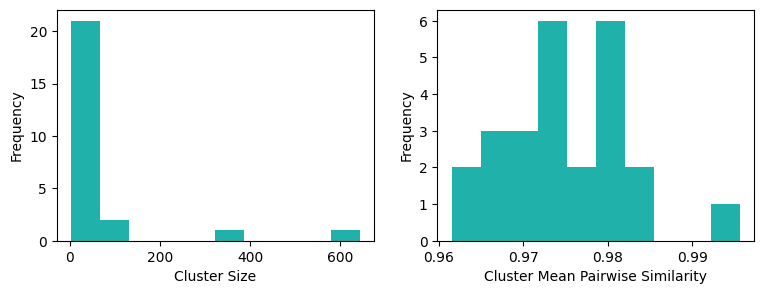

Num clusters = 25
autbrick stella farshortcontext hier
{np.int32(20): np.float32(0.9801545), np.int32(13): np.float32(0.9822737), np.int32(17): np.float32(0.9738867), np.int32(15): np.float32(0.96800023), np.int32(22): np.float32(0.98332685), np.int32(23): np.float32(0.97551143), np.int32(3): np.float32(0.97152627), np.int32(12): np.float32(0.98526627), np.int32(19): np.float32(0.9852913), np.int32(4): np.float32(0.9765513), np.int32(5): np.float32(0.978184), np.int32(9): np.float32(0.9886997), np.int32(14): np.float32(0.98813444), np.int32(2): np.float32(0.9727015), np.int32(6): np.float32(0.9723051), np.int32(7): np.float32(0.97509897), np.int32(18): np.float32(0.9861033), np.int32(16): np.float32(0.9671031), np.int32(25): np.float32(0.97022647), np.int32(1): np.float32(0.97486705), np.int32(24): np.float32(0.98303), np.int32(21): np.float32(0.973269), np.int32(11): np.float32(0.98552054), np.int32(10): np.float32(0.9874858), np.int32(8): np.float32(0.97649735)}


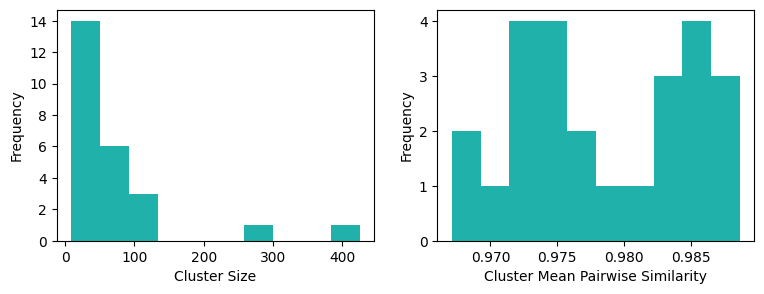

Num clusters = 25
autbrick stella farshortcontext kmeans
{np.int32(1): np.float32(0.9832068), np.int32(19): np.float32(0.9825877), np.int32(21): np.float32(0.97500896), np.int32(18): np.float32(0.98074293), np.int32(11): np.float32(0.9717117), np.int32(5): np.float32(0.98531497), np.int32(20): np.float32(0.96623874), np.int32(12): np.float32(0.9789012), np.int32(6): np.float32(0.9832992), np.int32(17): np.float32(0.97533953), np.int32(7): np.float32(0.9694055), np.int32(22): np.float32(0.9775369), np.int32(24): np.float32(0.97271264), np.int32(15): np.float32(0.9844809), np.int32(3): np.float32(0.976232), np.int32(9): np.float32(0.9712495), np.int32(16): np.float32(0.975034), np.int32(13): np.float32(0.9832898), np.int32(2): np.float32(0.98347324), np.int32(14): np.float32(0.9852728), np.int32(4): np.float32(0.9843861), np.int32(10): np.float32(0.97753376), np.int32(8): np.float32(0.9830142), np.int32(23): np.float32(0.9872531), np.int32(0): np.float32(0.99139184)}


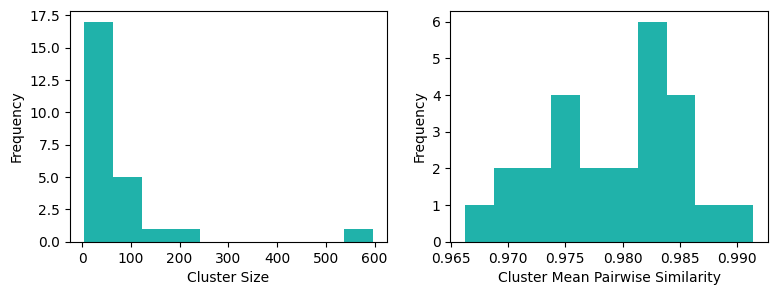

Num clusters = 25
autbrick gtelarge noshortcontext hier
{np.int32(22): np.float32(0.7994858), np.int32(14): np.float32(0.7616553), np.int32(5): np.float32(0.7838237), np.int32(12): np.float32(0.780747), np.int32(18): np.float32(0.790743), np.int32(25): np.float32(0.80181843), np.int32(24): np.float32(0.8132405), np.int32(21): np.float32(0.77457607), np.int32(4): np.float32(0.79791135), np.int32(11): np.float32(0.840915), np.int32(17): np.float32(0.7840406), np.int32(7): np.float32(0.84437424), np.int32(10): np.float32(0.78391147), np.int32(1): np.float32(0.8310797), np.int32(23): np.float32(0.8014949), np.int32(16): np.float32(0.80250806), np.int32(13): np.float32(0.78474814), np.int32(8): np.float32(0.8630264), np.int32(6): np.float32(0.8210741), np.int32(20): np.float32(0.79570115), np.int32(15): np.float32(0.8425733), np.int32(2): np.float32(0.7879658), np.int32(9): np.float32(0.84020776), np.int32(19): np.float32(0.8254583), np.int32(3): np.float32(0.8893036)}


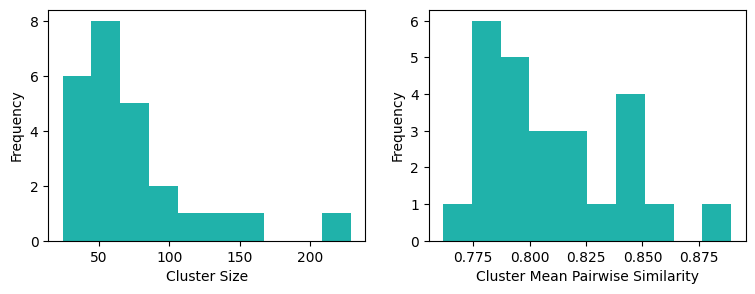

Num clusters = 25
autbrick gtelarge noshortcontext kmeans
{np.int32(23): np.float32(0.7684346), np.int32(4): np.float32(0.8214493), np.int32(2): np.float32(0.8174704), np.int32(17): np.float32(0.8084463), np.int32(9): np.float32(0.80316436), np.int32(16): np.float32(0.8369211), np.int32(6): np.float32(0.81850076), np.int32(24): np.float32(0.79540044), np.int32(3): np.float32(0.8331281), np.int32(12): np.float32(0.8025103), np.int32(18): np.float32(0.79694116), np.int32(14): np.float32(0.8267596), np.int32(15): np.float32(0.8074654), np.int32(8): np.float32(0.7985647), np.int32(11): np.float32(0.8043603), np.int32(5): np.float32(0.82468545), np.int32(22): np.float32(0.8092657), np.int32(13): np.float32(0.8377292), np.int32(20): np.float32(0.8406145), np.int32(19): np.float32(0.80471146), np.int32(1): np.float32(0.78946096), np.int32(21): np.float32(0.7812219), np.int32(0): np.float32(0.8304339), np.int32(7): np.float32(0.795203), np.int32(10): np.float32(0.90012765)}


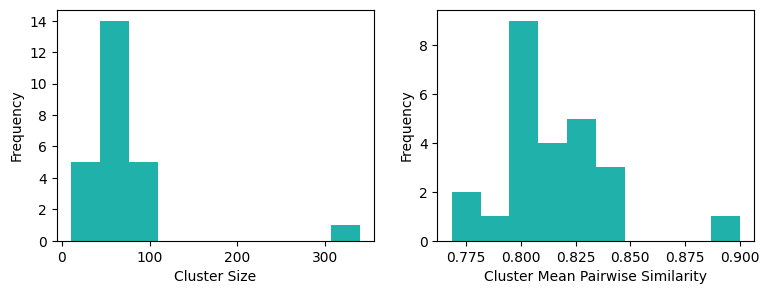

Num clusters = 25
autbrick gtelarge nearshortcontext hier
{np.int32(12): np.float32(0.9981013), np.int32(22): np.float32(0.9970698), np.int32(13): np.float32(0.99860036), np.int32(24): np.float32(0.99692196), np.int32(15): np.float32(0.9988421), np.int32(23): np.float32(0.9971798), np.int32(16): np.float32(0.9977553), np.int32(19): np.float32(0.99904203), np.int32(25): np.float32(0.9967505), np.int32(17): np.float32(0.99926853), np.int32(21): np.float32(0.99803245), np.int32(11): np.float32(0.974589), np.int32(2): np.float32(0.9968434), np.int32(14): np.float32(0.99667037), np.int32(5): np.float32(0.9943168), np.int32(4): np.float32(0.99231374), np.int32(10): np.float32(0.998102), np.int32(20): np.float32(0.9988034), np.int32(9): np.float32(0.9947044), np.int32(8): np.float32(0.99618965), np.int32(18): np.float32(0.99640894), np.int32(3): np.float32(0.9944946), np.int32(6): np.float32(0.99720305), np.int32(7): np.float32(0.9953789), np.int32(1): np.float32(0.9969533)}


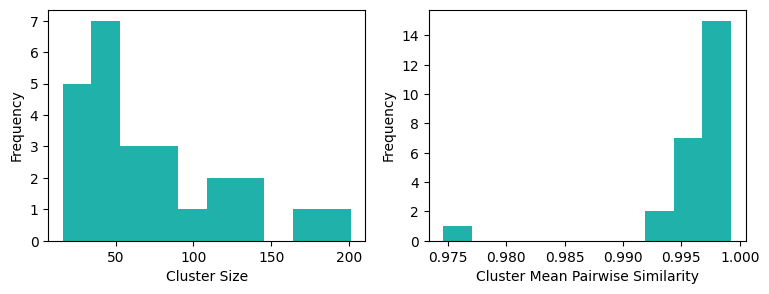

Num clusters = 25
autbrick gtelarge nearshortcontext kmeans
{np.int32(10): np.float32(0.99778783), np.int32(14): np.float32(0.9978373), np.int32(17): np.float32(0.99802023), np.int32(3): np.float32(0.9972296), np.int32(6): np.float32(0.9985619), np.int32(19): np.float32(0.9973908), np.int32(9): np.float32(0.9986465), np.int32(21): np.float32(0.9992919), np.int32(0): np.float32(0.99742496), np.int32(5): np.float32(0.99249846), np.int32(12): np.float32(0.99475044), np.int32(7): np.float32(0.99425805), np.int32(2): np.float32(0.9917268), np.int32(1): np.float32(0.99639446), np.int32(4): np.float32(0.9990152), np.int32(8): np.float32(0.9948449), np.int32(22): np.float32(0.9959416), np.int32(16): np.float32(0.9973769), np.int32(18): np.float32(0.9966686), np.int32(23): np.float32(0.99703544), np.int32(13): np.float32(0.9956344), np.int32(15): np.float32(0.9947774), np.int32(20): np.float32(0.994496), np.int32(24): np.float32(0.9999999), np.int32(11): np.float32(0.9945173)}


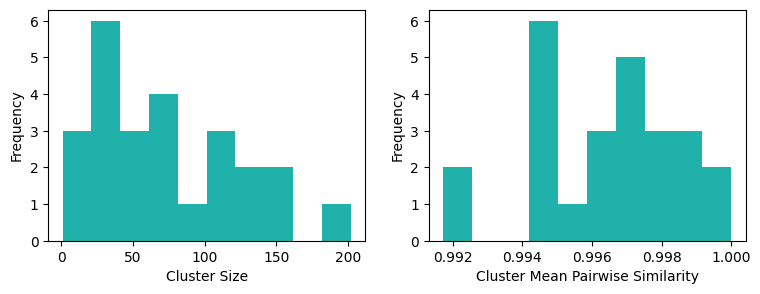

Num clusters = 25
autbrick gtelarge farshortcontext hier
{np.int32(11): np.float32(0.99684864), np.int32(5): np.float32(0.9937323), np.int32(6): np.float32(0.99351865), np.int32(13): np.float32(0.9718317), np.int32(4): np.float32(0.9975483), np.int32(2): np.float32(0.992151), np.int32(3): np.float32(0.99743134), np.int32(8): np.float32(0.9890595), np.int32(21): np.float32(0.992258), np.int32(18): np.float32(0.984971), np.int32(20): np.float32(0.99454385), np.int32(1): np.float32(0.9948966), np.int32(22): np.float32(0.9882352), np.int32(19): np.float32(0.9930809), np.int32(15): np.float32(0.98607343), np.int32(10): np.float32(0.9927212), np.int32(12): np.float32(0.9925283), np.int32(23): np.float32(0.98502123), np.int32(14): np.float32(0.9864012), np.int32(9): np.float32(0.9957284), np.int32(16): np.float32(0.99092484), np.int32(7): np.float32(0.9838697), np.int32(17): np.float32(0.98326766), np.int32(24): np.float32(0.99061656), np.int32(25): np.float32(0.9821957)}


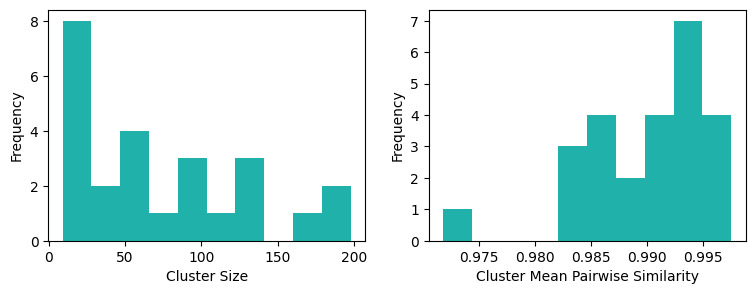

Num clusters = 25
autbrick gtelarge farshortcontext kmeans
{np.int32(11): np.float32(0.9944335), np.int32(4): np.float32(0.99462783), np.int32(10): np.float32(0.99654037), np.int32(3): np.float32(0.9929514), np.int32(8): np.float32(0.9756683), np.int32(5): np.float32(0.9964574), np.int32(15): np.float32(0.99498403), np.int32(22): np.float32(0.98881084), np.int32(18): np.float32(0.9928164), np.int32(19): np.float32(0.98583096), np.int32(17): np.float32(0.9867376), np.int32(6): np.float32(0.99300116), np.int32(13): np.float32(0.9918275), np.int32(16): np.float32(0.99161106), np.int32(21): np.float32(0.9920571), np.int32(1): np.float32(0.9941431), np.int32(2): np.float32(0.98607343), np.int32(20): np.float32(0.9815679), np.int32(7): np.float32(0.98514515), np.int32(23): np.float32(0.99529344), np.int32(12): np.float32(0.9884025), np.int32(9): np.float32(0.98436797), np.int32(14): np.float32(0.98975164), np.int32(24): np.float32(0.98575544), np.int32(0): np.float32(0.9907191)}


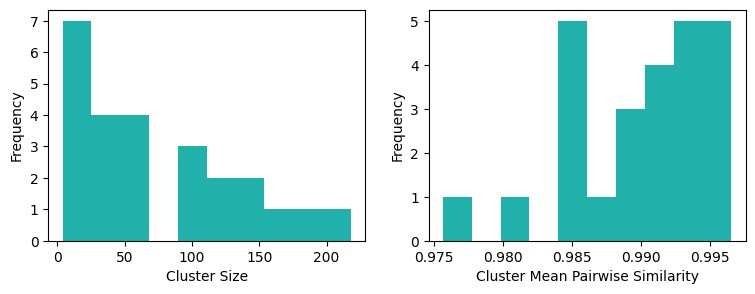

Num clusters = 25
autbrick jxm noshortcontext hier
{np.int32(2): np.float32(0.7987378), np.int32(4): np.float32(0.56117743), np.int32(22): np.float32(0.4370047), np.int32(21): np.float32(0.5233896), np.int32(3): np.float32(0.64270097), np.int32(19): np.float32(0.4788645), np.int32(17): np.float32(0.51291776), np.int32(9): np.float32(0.44882423), np.int32(15): np.float32(0.7302312), np.int32(16): np.float32(0.5589132), np.int32(7): np.float32(0.76342845), np.int32(1): np.float32(0.5934556), np.int32(13): np.float32(0.61494905), np.int32(23): np.float32(0.4109282), np.int32(24): np.float32(0.5525172), np.int32(12): np.float32(0.53673416), np.int32(14): np.float32(0.5435979), np.int32(11): np.float32(0.4223197), np.int32(25): np.float32(0.44509968), np.int32(6): np.float32(0.53890735), np.int32(18): np.float32(0.46913758), np.int32(5): np.float32(0.5654307), np.int32(10): np.float32(0.4732144), np.int32(8): np.float32(0.5790379), np.int32(20): np.float32(0.6106286)}


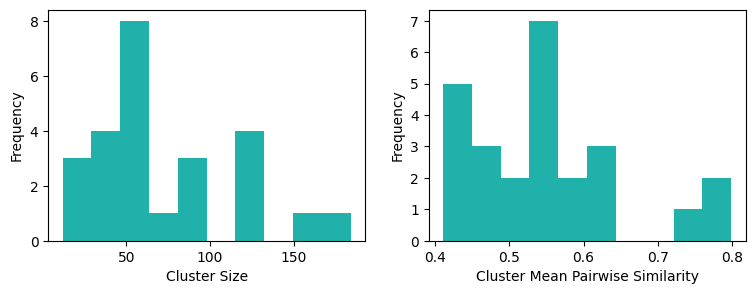

Num clusters = 25
autbrick jxm noshortcontext kmeans
{np.int32(12): np.float32(0.814984), np.int32(9): np.float32(0.50885737), np.int32(6): np.float32(0.4958656), np.int32(2): np.float32(0.58124614), np.int32(15): np.float32(0.5842603), np.int32(7): np.float32(0.5938101), np.int32(21): np.float32(0.5333962), np.int32(8): np.float32(0.42524266), np.int32(22): np.float32(0.5975973), np.int32(17): np.float32(0.6777966), np.int32(13): np.float32(0.63506454), np.int32(1): np.float32(0.5857593), np.int32(11): np.float32(0.50551283), np.int32(0): np.float32(0.45425257), np.int32(18): np.float32(0.515785), np.int32(20): np.float32(0.49780262), np.int32(5): np.float32(0.57183367), np.int32(3): np.float32(0.54268193), np.int32(16): np.float32(0.47000325), np.int32(19): np.float32(0.45038927), np.int32(14): np.float32(0.509481), np.int32(4): np.float32(0.54513586), np.int32(10): np.float32(0.5589388), np.int32(24): np.float32(0.48633593), np.int32(23): np.float32(0.5868745)}


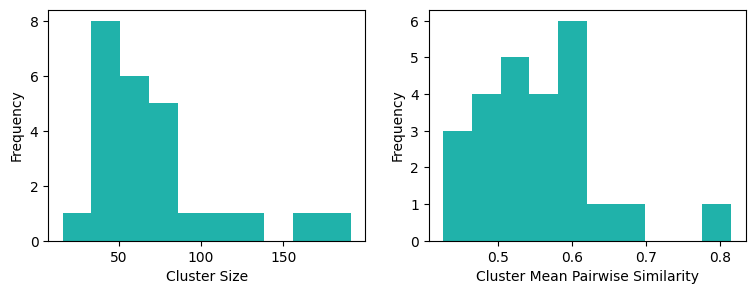

Num clusters = 25
autbrick jxm nearshortcontext hier


/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"jump_cat_{model}_{context}_{algo}"] = (~(data[f"category_{model}_{context}_{algo}"].diff() == 0)).astype(int)
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"jump_SS_{model}_{context}_{algo}"] = (data[f"SS_{model}_{context}_{algo}"] < 0.8).astype(int)
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7

{np.int32(4): np.float32(0.9996157), np.int32(25): np.float32(0.99957347), np.int32(5): np.float32(0.99953794), np.int32(23): np.float32(0.99953735), np.int32(18): np.float32(0.99952024), np.int32(24): np.float32(0.99967223), np.int32(22): np.float32(0.99943715), np.int32(20): np.float32(0.9995122), np.int32(17): np.float32(0.9992955), np.int32(15): np.float32(0.9994313), np.int32(21): np.float32(0.9995057), np.int32(14): np.float32(0.99953187), np.int32(7): np.float32(0.99940026), np.int32(8): np.float32(0.9995059), np.int32(13): np.float32(0.9995034), np.int32(1): np.float32(0.99918324), np.int32(3): np.float32(0.9993016), np.int32(19): np.float32(0.9993905), np.int32(9): np.float32(0.99937403), np.int32(11): np.float32(0.9994192), np.int32(16): np.float32(0.9986304), np.int32(10): np.float32(0.99934113), np.int32(12): np.float32(0.99886537), np.int32(6): np.float32(0.99778557), np.int32(2): np.float32(0.99828404)}


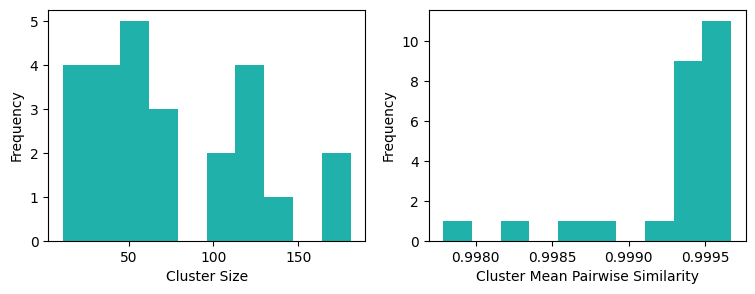

Num clusters = 25
autbrick jxm nearshortcontext kmeans


/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calcul

{np.int32(9): np.float32(0.9995217), np.int32(3): np.float32(0.9994588), np.int32(11): np.float32(0.999265), np.int32(0): np.float32(0.99941003), np.int32(4): np.float32(0.99950665), np.int32(21): np.float32(0.9992582), np.int32(19): np.float32(0.9995058), np.int32(10): np.float32(0.99954754), np.int32(20): np.float32(0.99956477), np.int32(15): np.float32(0.999443), np.int32(12): np.float32(0.99957067), np.int32(1): np.float32(0.99945253), np.int32(23): np.float32(0.9994494), np.int32(14): np.float32(0.99942815), np.int32(13): np.float32(0.99953264), np.int32(8): np.float32(0.99919975), np.int32(7): np.float32(0.9995453), np.int32(2): np.float32(0.9993865), np.int32(17): np.float32(0.99920577), np.int32(24): np.float32(0.99853987), np.int32(5): np.float32(0.9991454), np.int32(6): np.float32(0.99900174), np.int32(18): np.float32(0.9990156), np.int32(22): np.float32(0.9989614), np.int32(16): np.float32(0.999021)}


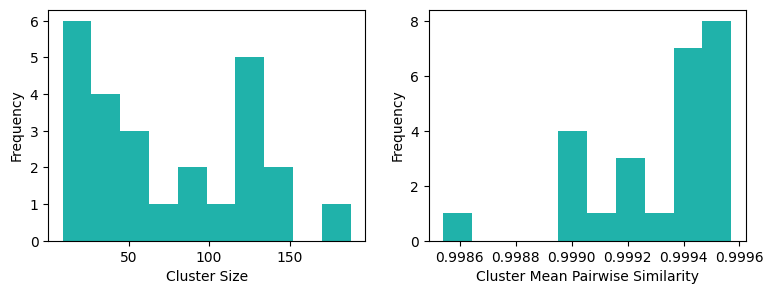

Num clusters = 25
autbrick jxm farshortcontext hier


/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calcul

{np.int32(6): np.float32(0.99951303), np.int32(7): np.float32(0.9996231), np.int32(9): np.float32(0.9997564), np.int32(14): np.float32(0.999547), np.int32(13): np.float32(0.99950945), np.int32(15): np.float32(0.99947286), np.int32(8): np.float32(0.9994748), np.int32(4): np.float32(0.9996209), np.int32(2): np.float32(0.9995063), np.int32(10): np.float32(0.99953306), np.int32(23): np.float32(0.9990963), np.int32(5): np.float32(0.9996002), np.int32(18): np.float32(0.9995645), np.int32(12): np.float32(0.9991486), np.int32(16): np.float32(0.9993974), np.int32(3): np.float32(0.9996805), np.int32(1): np.float32(0.9997158), np.int32(19): np.float32(0.9983363), np.int32(24): np.float32(0.9993832), np.int32(11): np.float32(0.99934447), np.int32(17): np.float32(0.99921006), np.int32(21): np.float32(0.9987492), np.int32(20): np.float32(0.9976636), np.int32(22): np.float32(0.99873286), np.int32(25): np.float32(0.9989646)}


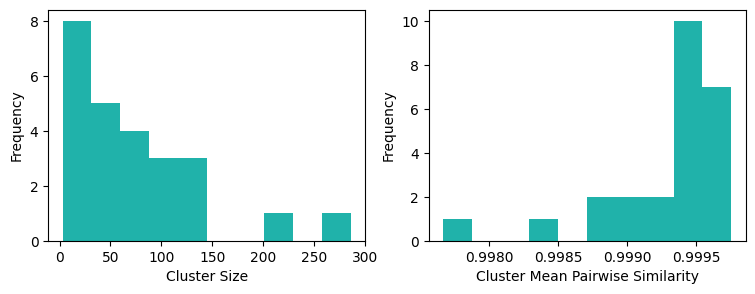

Num clusters = 25
autbrick jxm farshortcontext kmeans


/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calcul

{np.int32(5): np.float32(0.9996844), np.int32(18): np.float32(0.99960274), np.int32(12): np.float32(0.9997463), np.int32(9): np.float32(0.99962234), np.int32(20): np.float32(0.9994922), np.int32(6): np.float32(0.9994343), np.int32(2): np.float32(0.99960953), np.int32(10): np.float32(0.9996629), np.int32(14): np.float32(0.99953073), np.int32(23): np.float32(0.99952495), np.int32(13): np.float32(0.9990274), np.int32(24): np.float32(0.9996088), np.int32(1): np.float32(0.9996411), np.int32(0): np.float32(0.99922836), np.int32(19): np.float32(0.99947023), np.int32(22): np.float32(0.99950373), np.int32(3): np.float32(0.9995879), np.int32(11): np.float32(0.99925095), np.int32(4): np.float32(0.9996249), np.int32(17): np.float32(0.99828464), np.int32(8): np.float32(0.99922085), np.int32(16): np.float32(0.99882567), np.int32(7): np.float32(0.9976636), np.int32(21): np.float32(0.9993254), np.int32(15): np.float32(0.99884415)}


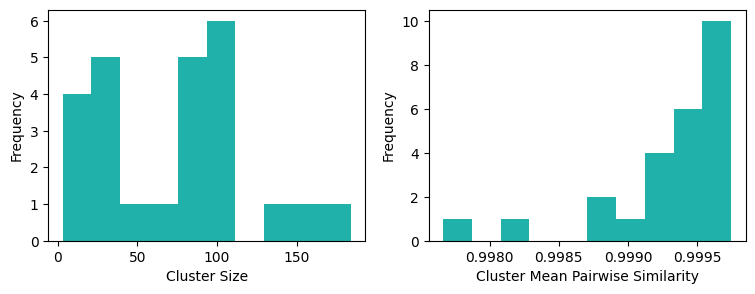

Num clusters = 25
autpaperclip qwen noshortcontext hier


/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"category_{model}_{context}_{algo}"] = data[data["task"] == taskid]["response"].apply(lambda x: response_to_cluster.get(x))
/var/folders/1j/673ty47d2bb32h1txb4tp05m0000gn/T/ipykernel_7743/159486977.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[data["task"] == taskid, f"SS_{model}_{context}_{algo}"] = data[data["task"] == taskid].apply(lambda row: calcul

{np.int32(1): np.float32(0.9776864), np.int32(17): np.float32(0.62997836), np.int32(19): np.float32(0.5725932), np.int32(22): np.float32(0.49069342), np.int32(13): np.float32(0.38935983), np.int32(8): np.float32(0.5608769), np.int32(23): np.float32(0.596873), np.int32(11): np.float32(0.4519918), np.int32(2): np.float32(0.64343977), np.int32(14): np.float32(0.47202164), np.int32(18): np.float32(0.6834117), np.int32(4): np.float32(0.45723057), np.int32(25): np.float32(0.69814366), np.int32(15): np.float32(0.5101239), np.int32(16): np.float32(0.47321844), np.int32(21): np.float32(0.48282206), np.int32(7): np.float32(0.39679193), np.int32(10): np.float32(0.64739805), np.int32(5): np.float32(0.73713076), np.int32(12): np.float32(0.50402844), np.int32(3): np.float32(0.56421155), np.int32(6): np.float32(0.38671228), np.int32(9): np.float32(0.49613187), np.int32(24): np.float32(0.68730396), np.int32(20): np.float32(0.7813936)}


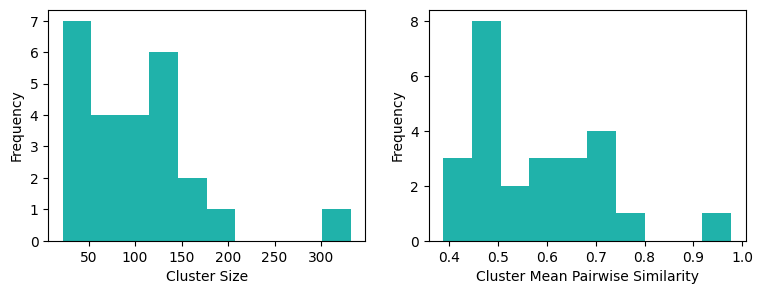

Num clusters = 25
autpaperclip qwen noshortcontext kmeans
{np.int32(2): np.float32(0.9776864), np.int32(20): np.float32(0.66431224), np.int32(14): np.float32(0.5645737), np.int32(7): np.float32(0.6666695), np.int32(24): np.float32(0.37851906), np.int32(16): np.float32(0.5603554), np.int32(5): np.float32(0.5104234), np.int32(23): np.float32(0.5447411), np.int32(19): np.float32(0.65277237), np.int32(4): np.float32(0.57422477), np.int32(11): np.float32(0.5014777), np.int32(10): np.float32(0.6603791), np.int32(18): np.float32(0.46771774), np.int32(6): np.float32(0.5451439), np.int32(9): np.float32(0.56764036), np.int32(21): np.float32(0.48268867), np.int32(12): np.float32(0.5308919), np.int32(0): np.float32(0.5271991), np.int32(8): np.float32(0.52804387), np.int32(15): np.float32(0.4936778), np.int32(1): np.float32(0.4083202), np.int32(22): np.float32(0.61968637), np.int32(17): np.float32(0.5572245), np.int32(3): np.float32(0.5357915), np.int32(13): np.float32(0.6672701)}


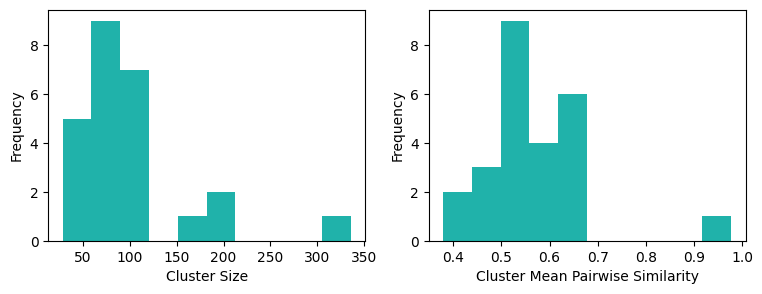

Num clusters = 25
autpaperclip qwen nearshortcontext hier
{np.int32(5): np.float32(0.9827267), np.int32(25): np.float32(0.9901075), np.int32(23): np.float32(0.9835591), np.int32(18): np.float32(0.9738575), np.int32(24): np.float32(0.99264896), np.int32(4): np.float32(0.9833192), np.int32(21): np.float32(0.9895368), np.int32(1): np.float32(0.98594666), np.int32(6): np.float32(0.9781562), np.int32(7): np.float32(0.9848644), np.int32(14): np.float32(0.9866476), np.int32(15): np.float32(0.98296684), np.int32(9): np.float32(0.9844074), np.int32(16): np.float32(0.9707041), np.int32(8): np.float32(0.9885056), np.int32(20): np.float32(0.9884303), np.int32(17): np.float32(0.9802246), np.int32(11): np.float32(0.98168695), np.int32(13): np.float32(0.99043524), np.int32(2): np.float32(0.9874526), np.int32(19): np.float32(0.9885089), np.int32(22): np.float32(0.98671436), np.int32(10): np.float32(0.97194546), np.int32(12): np.float32(0.98097557), np.int32(3): np.float32(0.9861325)}


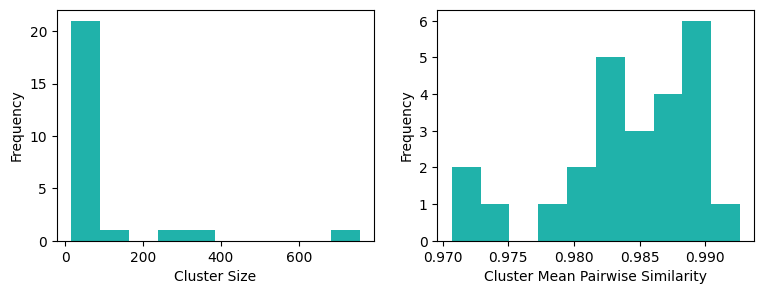

Num clusters = 25
autpaperclip qwen nearshortcontext kmeans
{np.int32(2): np.float32(0.9782323), np.int32(17): np.float32(0.9884942), np.int32(5): np.float32(0.98450285), np.int32(22): np.float32(0.98507786), np.int32(23): np.float32(0.9712448), np.int32(19): np.float32(0.9904557), np.int32(18): np.float32(0.98233366), np.int32(8): np.float32(0.9784228), np.int32(12): np.float32(0.98950815), np.int32(20): np.float32(0.987623), np.int32(24): np.float32(0.98410493), np.int32(3): np.float32(0.97441614), np.int32(7): np.float32(0.98973167), np.int32(15): np.float32(0.9884752), np.int32(0): np.float32(0.9862406), np.int32(14): np.float32(0.96861917), np.int32(1): np.float32(0.96939886), np.int32(21): np.float32(0.98491746), np.int32(6): np.float32(0.9855046), np.int32(11): np.float32(0.98695517), np.int32(10): np.float32(0.9828821), np.int32(16): np.float32(0.97911006), np.int32(4): np.float32(0.98933107), np.int32(13): np.float32(0.9885001), np.int32(9): np.float32(0.9825)}


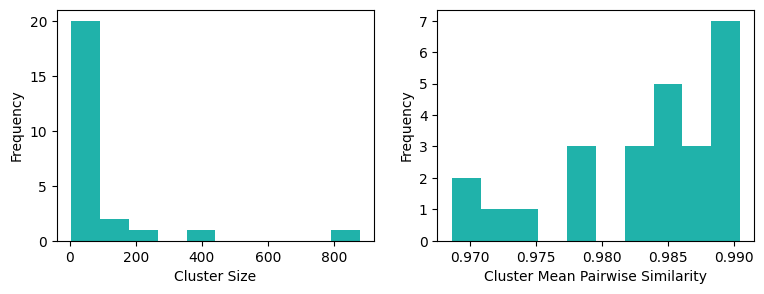

Num clusters = 25
autpaperclip qwen farshortcontext hier


In [ ]:
for i, textset in enumerate(texts):
    for model in models:
        for context in contexts:
            for algo in algos:
                print(tasks[i], model, context, algo)
                embeddings = pk.load(open(f"../embeddings/embeddings_{model}_{tasks[i]}_{context}.pk", "rb"))
                if algo == "hier":
                    response_to_cluster, cluster_to_response, num_clusters, minsim, meansim = perform_hierarchicalClustering(list(embeddings.values()), textset, ("maxclust", 25), printclusters)    # or ("distance", 1.89)
                elif algo == "kmeans":
                    response_to_cluster, cluster_to_response, num_clusters, minsim, meansim = permform_KMeans(list(embeddings.values()), textset, ("maxclust", 25), printclusters)    # or ("distance", 1.89)

                print("Num clusters =", num_clusters)
                write_category_SS_jump(taskid[i], model, context, algo, embeddings, response_to_cluster)

In [27]:
i = 0
d = {}
for task in tasks:
    for model in models:
        for context in contexts:
            for algo in algos:
                d[i] = f"{task}_{model}_{context}_{algo}" 
                i += 1

total_combinations = len(tasks) * len(models) * len(contexts) * len(algos)
agreement_matrix = np.empty((total_combinations, total_combinations), dtype=object)

for i in range(total_combinations):
    for j in range(i, total_combinations):
        task1, model1, context1, algo1 = d[i].split("_")
        task2, model2, context2, algo2 = d[j].split("_")
        try:
            cluster1 = data[data["task"] == task_to_id[task1]][f"category_{model1}_{context1}_{algo1}"]
            cluster2 = data[data["task"] == task_to_id[task2]][f"category_{model2}_{context2}_{algo2}"]
            agreement_matrix[i, j] = get_cluster_agreement(cluster1, cluster2)
        except:
            agreement_matrix[i, j] = "NA"


In [ ]:
df = pd.DataFrame(agreement_matrix, index=[d[i] for i in range(total_combinations)], columns=[d[i] for i in range(total_combinations)])
html = df.to_html(classes="table table-striped table-bordered", index=True)

# Add CSS for freezing the header and the first column
style = """
    <style>
        .dataframe tbody tr th {
            position: sticky;
            left: 0;
            background-color: #000000;
            z-index: 1;
        }
        .dataframe thead th {
            position: sticky;
            top: 0;
            background-color: #000000;
            z-index: 2;
        }
        .dataframe {
            width: 100%;
            height: 400px;
            overflow: auto;
            display: block;
        }
    </style>
"""

# Display the styled DataFrame with frozen header and first column
display(HTML(style + html))

In [15]:
# Resetting the total combinations
total_combinations = len(tasks) * len(models) * len(contexts) * len(algos)

# Initialize the 72x72 agreement matrix
agreement_matrix = np.empty((total_combinations, total_combinations), dtype=object)

# Function to get a flat index for combinations of task, model, context, and algo
def get_flat_index(task_idx, model_idx, context_idx, algo_idx):
    return (task_idx * len(models) * len(contexts) * len(algos) +
            model_idx * len(contexts) * len(algos) +
            context_idx * len(algos) +
            algo_idx)

# Loop over all combinations and fill the matrix correctly
for task1_idx, task1 in enumerate(tasks):
    for task2_idx, task2 in enumerate(tasks):
        for model1_idx, model1 in enumerate(models):
            for model2_idx, model2 in enumerate(models):
                for context1_idx, context1 in enumerate(contexts):
                    for context2_idx, context2 in enumerate(contexts):
                        for algo1_idx, algo1 in enumerate(algos):
                            for algo2_idx, algo2 in enumerate(algos):
                                # Get flat indices for the matrix
                                flat_idx1 = get_flat_index(task1_idx, model1_idx, context1_idx, algo1_idx)
                                flat_idx2 = get_flat_index(task2_idx, model2_idx, context2_idx, algo2_idx)

                                # Build the column names dynamically
                                category1 = f"category_{model1}_{context1}_{algo1}"
                                category2 = f"category_{model2}_{context2}_{algo2}"
                                cluster1 = data[data["task"] == taskid[task1_idx]][category1]
                                cluster2 = data[data["task"] == taskid[task2_idx]][category2]

                                # print(task1_idx, model1, context1, algo1, task2_idx, model2, context2, algo2)
                                try: 
                                    agreement_matrix[flat_idx1, flat_idx2] = get_cluster_agreement(cluster1, cluster2)
                                except:
                                    agreement_matrix[flat_idx1, flat_idx2] = np.nan

In [ ]:
pd.DataFrame(agreement_matrix)

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "hier"
model2 = "gtelarge"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[data["task"] == 2][f"category_{model1}_{context1}_{algo1}"], data[data["task"] == 2][f"category_{model2}_{context2}_{algo2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "hier"
model2 = "gtelarge"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[data["task"] == 3][f"category_{model1}_{context1}_{algo1}"], data[data["task"] == 3][f"category_{model2}_{context2}_{algo2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "hier"
model2 = "gtelarge"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[data["task"] == 1][f"category_{model1}_{context1}_{algo1}"], data[data["task"] == 1][f"category_{model2}_{context2}_{algo2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "hier"
model2 = "gtelarge"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[f"category_{model1}_{context1}_{algo1}"], data[f"category_{model2}_{context2}_{algo2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
algo1 = "kmeans"
model2 = "stella"
context2 = "noshortcontext"
algo2 = "kmeans"

get_cluster_agreement(data[f"category_{model1}_{context1}_{algo1}"], data[f"category_{model2}_{context2}_{algo2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
model2 = "stella"
context2 = "farshortcontext"

get_cluster_agreement(data[f"category_{model1}_{context1}"], data[f"category_{model2}_{context2}"])

In [ ]:
model1 = "gtelarge"
context1 = "nearshortcontext"
model2 = "gtelarge"
context2 = "farshortcontext"

get_cluster_agreement(data[f"category_{model1}_{context1}"], data[f"category_{model2}_{context2}"])

In [ ]:
model1 = "gtelarge"
context1 = "noshortcontext"
model2 = "stella"
context2 = "noshortcontext"

get_cluster_agreement(data[f"category_{model1}_{context1}"], data[f"category_{model2}_{context2}"])

In [ ]:
model1 = "gtelarge"
context1 = "nearshortcontext"
model2 = "stella"
context2 = "nearshortcontext"

get_cluster_agreement(data[f"category_{model1}_{context1}"], data[f"category_{model2}_{context2}"])

In [ ]:
model1 = "gtelarge"
context1 = "farshortcontext"
model2 = "stella"
context2 = "farshortcontext"

get_cluster_agreement(data[f"category_{model1}_{context1}"], data[f"category_{model2}_{context2}"])